# Introduction
I ran all my code within this jupyter notebook. To run it locally, you'd need to download the csv file to the directory path `../input/Eluvio_DS_Challenge.csv`. Also, you'd have to make sure you have all the dependencies installed (Sorry I didn't make a requirements.txt).

Below is an outline of what I did.

> 1. Exploration of dataset
> 2. Topic Modelling with LDA
> 3. Predictive modelling for "over_18" flag using BERT

I'd generally approach any new dataset with some sort of EDA. I chose to do topic modelling because it could be a way to see what the main themes of world news have been. Lastly, I wanted to create some sort of deep learning predictive model, and I thought it'd be fun to use BERT for the first time.

In [42]:
# data downloaded from https://drive.google.com/uc?authuser=0&id=15X00ZWBjla7qGOIW33j8865QdF89IyAk
import os
import matplotlib.pyplot as plt
import collections
import nltk

import seaborn as sns
import numpy as np
import pandas as pd
import math
import sklearn
from sklearn.decomposition import LatentDirichletAllocation

%matplotlib inline

In [43]:
def date_to_year_quarter(date):
    year, month, _ = date.split("-")
    # No years are earlier than 2000
    return year[-2:] + "Q" + str(math.ceil((int(month) - .1)/ 4.0))

## 1. Exploration

We're going to explore the data, and give a short summary about what we learned about each feature.

In [44]:
data = pd.read_csv("../input/Eluvio_DS_Challenge.csv")

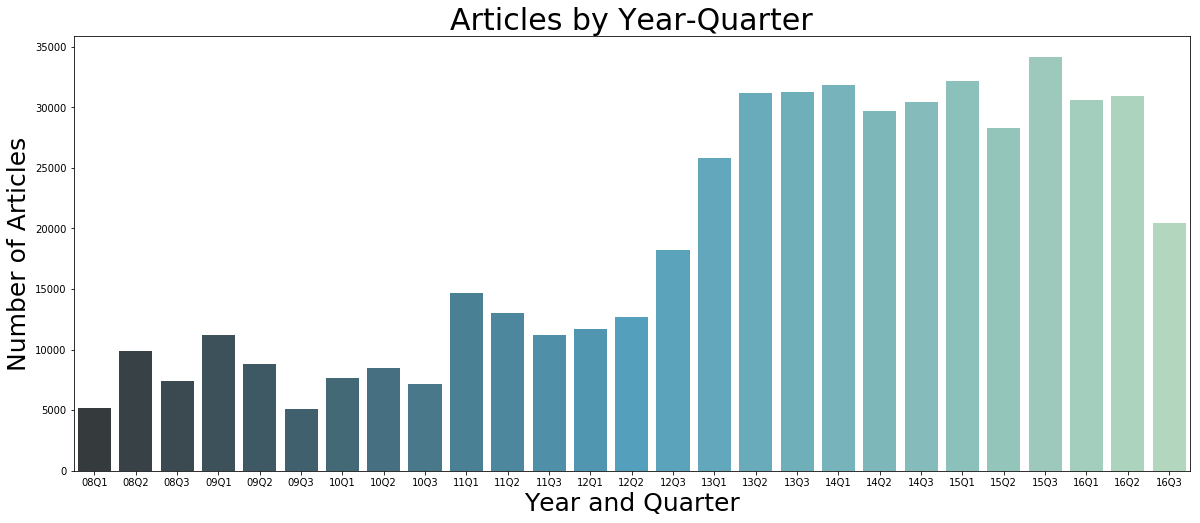

In [45]:
plt.figure(figsize=(20,8))
data['datetime_created'] = pd.to_datetime(data['date_created'])
articles_by_month = data['date_created'].apply(date_to_year_quarter).value_counts().sort_index()
ax = sns.barplot(articles_by_month.index, articles_by_month.values, palette="GnBu_d")
ax.set_xlabel("Year and Quarter", fontsize=25)
ax.set_ylabel("Number of Articles", fontsize=25)
ax.set_title("Articles by Year-Quarter", fontsize=30)
plt.show()

In [46]:
print(data['up_votes'].describe())
print("99.5% of articles have less than " + str(data['up_votes'].quantile(.995)) + " upvotes")
print(str((data["up_votes"] == 0).sum()) + " articles have zero upvotes, around less than 1/5")

count    509236.000000
mean        112.236283
std         541.694675
min           0.000000
25%           1.000000
50%           5.000000
75%          16.000000
max       21253.000000
Name: up_votes, dtype: float64
99.5% of articles have less than 4227.825000000012 upvotes
93555 articles have zero upvotes, around less than 1/5


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


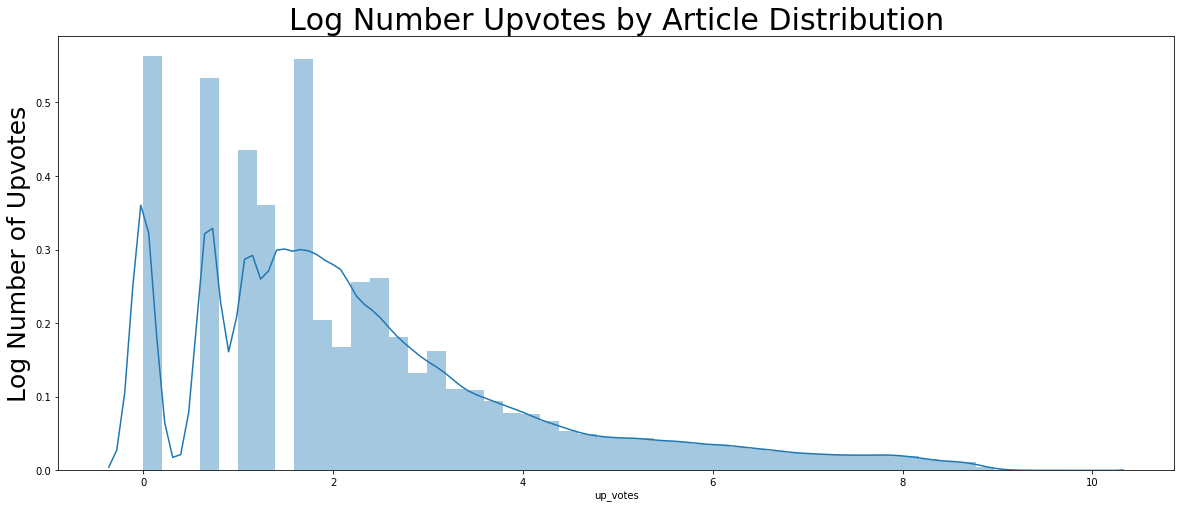

In [47]:
plt.figure(figsize=(20,8))
ax = sns.distplot(data[data['up_votes'] > 0]['up_votes'].apply(lambda x: math.log(x)))
ax.set_ylabel("Log Number of Upvotes", fontsize=25)
ax.set_title("Log Number Upvotes by Article Distribution", fontsize=30)
plt.show()

In [48]:
data["over_18"].value_counts()

False    508916
True        320
Name: over_18, dtype: int64

In [49]:
data['down_votes'].value_counts()

0    509236
Name: down_votes, dtype: int64

In [50]:
# category can be ignored
data["category"].value_counts()

worldnews    509236
Name: category, dtype: int64

In [51]:
articles_by_author = data['author'].value_counts()
articles_by_author.describe()

count    85838.000000
mean         5.932524
std         62.282937
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max       8897.000000
Name: author, dtype: float64

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


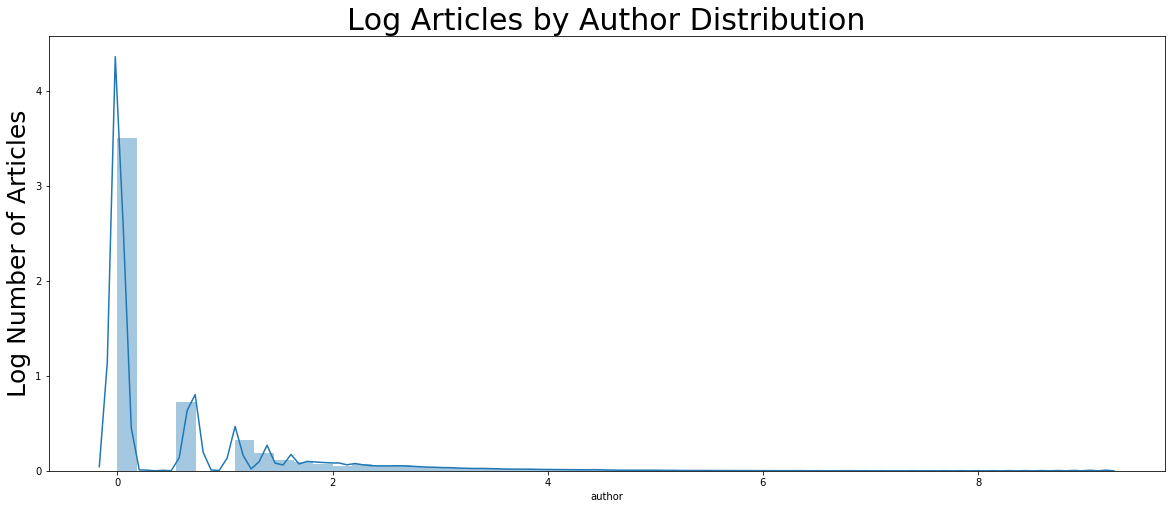

In [52]:
plt.figure(figsize=(20,8))
ax = sns.distplot(articles_by_author.apply(lambda x: math.log(x)))
ax.set_ylabel("Log Number of Articles", fontsize=25)
ax.set_title("Log Articles by Author Distribution", fontsize=30)
plt.show()

In [53]:
# title's word count statistics
data['title'].apply(lambda x : len(x.split())).describe()

count    509236.000000
mean         14.439048
std           9.881765
min           1.000000
25%           8.000000
50%          11.000000
75%          16.000000
max          64.000000
Name: title, dtype: float64

In [54]:
# title's character count statistics
data['title'].apply(lambda x : len(x)).describe()

count    509236.000000
mean         89.446082
std          59.701217
min           1.000000
25%          52.000000
50%          66.000000
75%         100.000000
max         320.000000
Name: title, dtype: float64

In [55]:
# Most commonly used words across all titles
corpus = ' '.join(data['title'].values).lower().split()
word_counts = collections.Counter(corpus)
word_counts.most_common(300)

[('to', 211379),
 ('the', 211037),
 ('in', 207169),
 ('of', 174213),
 ('a', 107138),
 ('and', 86212),
 ('for', 79882),
 ('s', 78800),
 ('on', 72805),
 ('is', 42008),
 ('-', 40879),
 ('with', 39201),
 ('as', 39063),
 ('by', 37424),
 ('from', 35097),
 ('at', 32392),
 ('has', 29157),
 ('after', 29053),
 ('that', 28984),
 ('over', 24707),
 ('says', 24460),
 ('new', 23133),
 ('china', 22061),
 ('us', 21573),
 ('have', 21560),
 ('be', 21271),
 ('are', 20679),
 ('it', 20051),
 ('an', 19068),
 ('will', 16587),
 ('police', 15701),
 ('russia', 15504),
 ('syria', 15318),
 ('was', 15199),
 ('world', 15059),
 ('u.s.', 15021),
 ('its', 14991),
 ('against', 14876),
 ('not', 14334),
 ('more', 14148),
 ('government', 14017),
 ('president', 13615),
 ('israel', 13351),
 ('iran', 13337),
 ('killed', 13202),
 ('who', 12665),
 ('people', 12210),
 ('his', 11561),
 ('up', 11432),
 ('state', 11423),
 ('russian', 11403),
 ('attack', 11380),
 ('military', 11291),
 ('their', 11209),
 ('north', 11104),
 ('south', 

#### Learnings:
* The dataset has articles from 2008-2016 with more collected from 2013 onward
* up_votes distribution highly skewed towards the right
* Less than .1% of articles are over_18
* down_votes and category features only have 1 unique value
* Most authors only write 1 article. Distribution of number of articles by author highly skewed to the right
* We calculated some title word and character count stats. Most frequent words seem to match what you hear in the news

# 2. Topic Modeling
Lets get a better idea of world news subject matter with some LDA topic modelling

In [56]:
# https://stackoverflow.com/questions/45145368/python-scikit-learn-get-documents-per-topic-in-lda
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))                        

    print()

Below, I tried searching for best number of topics using the log-likelihood score metric for LDA. This ended up not being that useful since the score decreased montonically with topic number (I tested it on n_topics 1 to 8 previously). Instead, I just looked at, conceptually, what created the most coherent topics.

In [57]:
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
    stop_words=set(nltk.corpus.stopwords.words('english')),
)

word_vectors = vectorizer.fit_transform(data['title'].values)
feature_names = vectorizer.get_feature_names()

In [ ]:

lda_scores = {}
ldas = {}
for n_topics in [8, 10, 12]:
    lda = LatentDirichletAllocation(n_topics=n_topics, random_state=0).fit(word_vectors)
    score = lda.score(word_vectors)
    ldas[n_topics] = lda
    lda_scores[n_topics] = score
    print("n_topics: {} score: {}".format(n_topics, score))

/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


n_topics: 8 score: -14935449.251805702


/opt/conda/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


Below are the top 10 words associated for each topic, running LDA on n_topics=10

In [ ]:
#for n_topics, lda in ldas.items():
#    print_top_words(lda, feature_names, 10)
print_top_words(ldas[10], feature_names, 10)

#### Takeaways from topic modelling
I ended up choosing 10 topics because it seemed to produce the most coherent topics.
- Topic #0 is related to the Catholic church
- Topic #3 relates to the EU
- Topic #4 has many violence related words
- Topic #7 relates to war in the Middle East

A lot more could be explored with Topic Modelling, such as looking at which titles are most representative of each topic or visualizing how similar topics cluster together. Also, more work can be put into the topic selection, such as choosing different criteria for number of topics and messing around with the hyperparameters of the LDA algorithm. Overall, though, I think the topic modelling we've done helps to describe the content of these news articles.

### 3. Predicting over_18 with BERT

In [1]:
!pip install bert-tensorflow

    100% |████████████████████████████████| 71kB 8.0MB/s ta 0:00:011
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [24]:
from datetime import datetime
import random
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow_hub as hub
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization

%matplotlib inline

In [3]:
data = pd.read_csv("../input/Eluvio_DS_Challenge.csv")

We're going to try to create a model to predict the over_18 flag for news articles based on headlines. This could be useful for auto-flagging of articles unsuitable for children.

To create this model, we'll be using BERT, which is a pretrained neural net that is commonly used for NLP classification problems. We'll be fine-tuning BERT to classify headlines as over_18 or not.

From the data exploration, we learned that the over_18 flag is False for more than 99.5% of the headlines. This means we'll have an unbalanced classes problem, which we can hope to mitigate by using focal loss (https://arxiv.org/abs/1708.02002), which is a special loss function.

Also, as can be seen from the code below, around half of the over_18 headlines have the acronyms 'NSFW' or 'NSFL'. I'm going to remove these acronyms from the headlines because it's possible that these labels were added by a some news regulator, and it would also give our model an unfair advantage.

Much of the code was taken/influenced by https://colab.research.google.com/github/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb#scrollTo=p9gEt5SmM6i6

In [4]:
over_18 = data[data['over_18'] == True]
not_over_18 = data[data['over_18'] == False]
over_18_contains_nsf = over_18['title'].apply(lambda x: 'nsfw' in x.lower() or 'nsfl' in x.lower())
not_over_18_contains_nsf = not_over_18['title'].apply(lambda x: 'nsfw' in x.lower() or 'nsfl' in x.lower())

In [5]:
# Around half of over_18 articles contain the acronym NSFW or NSFL
over_18_contains_nsf.value_counts()

False    172
True     148
Name: title, dtype: int64

In [6]:
# Non-over_18 articles don't contain NSFW/NSFL
not_over_18_contains_nsf.value_counts()

False    508916
Name: title, dtype: int64

Since we are computationally constrained and there's such a large class imbalance anyways, I'm going to randomly remove 90% of the not over_18 data.

In [7]:
random.seed(0)

# Randomly remove 90% of the dominant class
flagged_index = data.index[data["over_18"] == True]
non_flagged_index = data.index[data["over_18"] == False]
selected_index = random.sample(
    list(non_flagged_index),
    int(.1 * len(non_flagged_index))
)
selected_index.extend(flagged_index)
data = data.iloc[sorted(selected_index)]

In [8]:
MAX_SEQ_LENGTH = 128
LABEL_LIST = [False, True]
GAMMA = 2.0
ALPHA =.25
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 500
SAVE_SUMMARY_STEPS = 100
OUTPUT_DIR = "../"

In [9]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

Instructions for updating:
Colocations handled automatically by placer.


W0614 01:34:36.294144 140533437306240 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0614 01:34:38.578668 140533437306240 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [10]:
def text_process(text):
    # remove NSFW, NSFL and the brackets that sometimes surround them
    text = text.replace("NSFW", "")
    text = text.replace("NSFL", "")
    text = text.replace("nsfw", "")
    text = text.replace("nsfl", "")
    text = text.replace("[", "")
    text = text.replace("(", "")
    text = text.replace("]", "")
    text = text.replace(")", "")

    #text = text[:MAX_SEQUENCE_LENGTH]

    return text

In [11]:
def process_inputs(x, y):
    """
    @X is dataframe
    @y is list of True/False values
    """

    x = x['title'].apply(text_process).values
    input_examples = [
        bert.run_classifier.InputExample(
            guid=None, # Globally unique ID for bookkeeping, unused in this example
            text_a=_x, 
            text_b=None, 
            label=_y
        ) for _x, _y in zip(x, y)
    ]

    features = bert.run_classifier.convert_examples_to_features(
        input_examples,
        LABEL_LIST,
        MAX_SEQ_LENGTH,
        tokenizer
    )

    y = [1 if _y == True else 0 for _y in y]

    return features, y

In [31]:
# 80%, 10%, 10% splits
X_train, X_test, y_train, y_test = train_test_split(
    data[['title']],
    data['over_18'].values,
    test_size=0.2,
    random_state=0,
    stratify=data['over_18'].values
)

X_val, X_test, y_val, y_test = train_test_split(
    X_test,
    y_test,
    test_size=0.5,
    random_state=0,
    stratify=y_test
)

_X_train, _X_test, _X_val = X_train, X_test, X_val

In [32]:
X_train, y_train = process_inputs(X_train, y_train)
X_test, y_test = process_inputs(X_test, y_test)
X_val, y_val = process_inputs(X_val, y_val)

INFO:tensorflow:Writing example 0 of 40968


I0614 02:58:47.411228 140533437306240 run_classifier.py:774] Writing example 0 of 40968


INFO:tensorflow:*** Example ***


I0614 02:58:47.419841 140533437306240 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0614 02:58:47.421677 140533437306240 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] russia calls for military tribunal on hiroshima and nagasaki [SEP]


I0614 02:58:47.428082 140533437306240 run_classifier.py:464] tokens: [CLS] russia calls for military tribunal on hiroshima and nagasaki [SEP]


INFO:tensorflow:input_ids: 101 3607 4455 2005 2510 12152 2006 20168 1998 27107 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:58:47.429464 140533437306240 run_classifier.py:465] input_ids: 101 3607 4455 2005 2510 12152 2006 20168 1998 27107 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:58:47.431223 140533437306240 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:58:47.434907 140533437306240 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: False (id = 0)


I0614 02:58:47.436100 140533437306240 run_classifier.py:468] label: False (id = 0)


INFO:tensorflow:*** Example ***


I0614 02:58:47.437446 140533437306240 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0614 02:58:47.438495 140533437306240 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] russian soyuz space capsule returns to earth . [SEP]


I0614 02:58:47.439516 140533437306240 run_classifier.py:464] tokens: [CLS] russian soyuz space capsule returns to earth . [SEP]


INFO:tensorflow:input_ids: 101 2845 29412 2686 18269 5651 2000 3011 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:58:47.440583 140533437306240 run_classifier.py:465] input_ids: 101 2845 29412 2686 18269 5651 2000 3011 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:58:47.441574 140533437306240 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:58:47.442719 140533437306240 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: False (id = 0)


I0614 02:58:47.443811 140533437306240 run_classifier.py:468] label: False (id = 0)


INFO:tensorflow:*** Example ***


I0614 02:58:47.445325 140533437306240 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0614 02:58:47.446295 140533437306240 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] south african employer of firefighters apologize ##s for international incident after pay dispute - fort mc ##mur ##ray [SEP]


I0614 02:58:47.447228 140533437306240 run_classifier.py:464] tokens: [CLS] south african employer of firefighters apologize ##s for international incident after pay dispute - fort mc ##mur ##ray [SEP]


INFO:tensorflow:input_ids: 101 2148 3060 11194 1997 21767 12134 2015 2005 2248 5043 2044 3477 7593 1011 3481 11338 20136 9447 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:58:47.448194 140533437306240 run_classifier.py:465] input_ids: 101 2148 3060 11194 1997 21767 12134 2015 2005 2248 5043 2044 3477 7593 1011 3481 11338 20136 9447 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:58:47.449238 140533437306240 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:58:47.450193 140533437306240 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: False (id = 0)


I0614 02:58:47.451107 140533437306240 run_classifier.py:468] label: False (id = 0)


INFO:tensorflow:*** Example ***


I0614 02:58:47.452329 140533437306240 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0614 02:58:47.453322 140533437306240 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] iranian diplomats given 48 hours to leave saudi arabia [SEP]


I0614 02:58:47.454243 140533437306240 run_classifier.py:464] tokens: [CLS] iranian diplomats given 48 hours to leave saudi arabia [SEP]


INFO:tensorflow:input_ids: 101 7726 23473 2445 4466 2847 2000 2681 8174 9264 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:58:47.455277 140533437306240 run_classifier.py:465] input_ids: 101 7726 23473 2445 4466 2847 2000 2681 8174 9264 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:58:47.456254 140533437306240 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:58:47.457250 140533437306240 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: False (id = 0)


I0614 02:58:47.458230 140533437306240 run_classifier.py:468] label: False (id = 0)


INFO:tensorflow:*** Example ***


I0614 02:58:47.459480 140533437306240 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0614 02:58:47.460424 140533437306240 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] migrant crisis : slovenia sets limit of 2 , 500 people a day [SEP]


I0614 02:58:47.461407 140533437306240 run_classifier.py:464] tokens: [CLS] migrant crisis : slovenia sets limit of 2 , 500 people a day [SEP]


INFO:tensorflow:input_ids: 101 20731 5325 1024 10307 4520 5787 1997 1016 1010 3156 2111 1037 2154 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:58:47.462529 140533437306240 run_classifier.py:465] input_ids: 101 20731 5325 1024 10307 4520 5787 1997 1016 1010 3156 2111 1037 2154 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:58:47.463613 140533437306240 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:58:47.464610 140533437306240 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: False (id = 0)


I0614 02:58:47.465557 140533437306240 run_classifier.py:468] label: False (id = 0)


INFO:tensorflow:Writing example 10000 of 40968


I0614 02:58:51.452581 140533437306240 run_classifier.py:774] Writing example 10000 of 40968


INFO:tensorflow:Writing example 20000 of 40968


I0614 02:58:55.317874 140533437306240 run_classifier.py:774] Writing example 20000 of 40968


INFO:tensorflow:Writing example 30000 of 40968


I0614 02:58:59.108209 140533437306240 run_classifier.py:774] Writing example 30000 of 40968


INFO:tensorflow:Writing example 40000 of 40968


I0614 02:59:02.904910 140533437306240 run_classifier.py:774] Writing example 40000 of 40968


INFO:tensorflow:Writing example 0 of 5122


I0614 02:59:03.351816 140533437306240 run_classifier.py:774] Writing example 0 of 5122


INFO:tensorflow:*** Example ***


I0614 02:59:03.355203 140533437306240 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0614 02:59:03.358807 140533437306240 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] 97 - year - old cleared of war crimes by hungary court [SEP]


I0614 02:59:03.361052 140533437306240 run_classifier.py:464] tokens: [CLS] 97 - year - old cleared of war crimes by hungary court [SEP]


INFO:tensorflow:input_ids: 101 5989 1011 2095 1011 2214 5985 1997 2162 6997 2011 5872 2457 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:59:03.364423 140533437306240 run_classifier.py:465] input_ids: 101 5989 1011 2095 1011 2214 5985 1997 2162 6997 2011 5872 2457 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:59:03.366540 140533437306240 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:59:03.368681 140533437306240 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: False (id = 0)


I0614 02:59:03.372481 140533437306240 run_classifier.py:468] label: False (id = 0)


INFO:tensorflow:*** Example ***


I0614 02:59:03.374508 140533437306240 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0614 02:59:03.375922 140533437306240 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] david axe suggests drone coalition of u . s . , s . korea , japan & australia to monitor n . korea & china [SEP]


I0614 02:59:03.377475 140533437306240 run_classifier.py:464] tokens: [CLS] david axe suggests drone coalition of u . s . , s . korea , japan & australia to monitor n . korea & china [SEP]


INFO:tensorflow:input_ids: 101 2585 12946 6083 18465 6056 1997 1057 1012 1055 1012 1010 1055 1012 4420 1010 2900 1004 2660 2000 8080 1050 1012 4420 1004 2859 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:59:03.383226 140533437306240 run_classifier.py:465] input_ids: 101 2585 12946 6083 18465 6056 1997 1057 1012 1055 1012 1010 1055 1012 4420 1010 2900 1004 2660 2000 8080 1050 1012 4420 1004 2859 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:59:03.384535 140533437306240 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:59:03.385786 140533437306240 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: False (id = 0)


I0614 02:59:03.387038 140533437306240 run_classifier.py:468] label: False (id = 0)


INFO:tensorflow:*** Example ***


I0614 02:59:03.389014 140533437306240 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0614 02:59:03.390274 140533437306240 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] “ if pakistan doesn t public ##ize its cooperation with the u . s . , pakistan will be in serious trouble on the diplomatic front . ” [SEP]


I0614 02:59:03.391433 140533437306240 run_classifier.py:464] tokens: [CLS] “ if pakistan doesn t public ##ize its cooperation with the u . s . , pakistan will be in serious trouble on the diplomatic front . ” [SEP]


INFO:tensorflow:input_ids: 101 1523 2065 4501 2987 1056 2270 4697 2049 6792 2007 1996 1057 1012 1055 1012 1010 4501 2097 2022 1999 3809 4390 2006 1996 8041 2392 1012 1524 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:59:03.401606 140533437306240 run_classifier.py:465] input_ids: 101 1523 2065 4501 2987 1056 2270 4697 2049 6792 2007 1996 1057 1012 1055 1012 1010 4501 2097 2022 1999 3809 4390 2006 1996 8041 2392 1012 1524 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:59:03.403132 140533437306240 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:59:03.404738 140533437306240 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: False (id = 0)


I0614 02:59:03.406379 140533437306240 run_classifier.py:468] label: False (id = 0)


INFO:tensorflow:*** Example ***


I0614 02:59:03.409028 140533437306240 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0614 02:59:03.410519 140533437306240 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] the eu general court has ordered that the palestinian militant group hamas be removed from the bloc ’ s terror black ##list . the move comes over four years after hamas appealed its terror designation before the eu . [SEP]


I0614 02:59:03.411984 140533437306240 run_classifier.py:464] tokens: [CLS] the eu general court has ordered that the palestinian militant group hamas be removed from the bloc ’ s terror black ##list . the move comes over four years after hamas appealed its terror designation before the eu . [SEP]


INFO:tensorflow:input_ids: 101 1996 7327 2236 2457 2038 3641 2008 1996 9302 16830 2177 22129 2022 3718 2013 1996 15984 1521 1055 7404 2304 9863 1012 1996 2693 3310 2058 2176 2086 2044 22129 12068 2049 7404 8259 2077 1996 7327 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:59:03.413526 140533437306240 run_classifier.py:465] input_ids: 101 1996 7327 2236 2457 2038 3641 2008 1996 9302 16830 2177 22129 2022 3718 2013 1996 15984 1521 1055 7404 2304 9863 1012 1996 2693 3310 2058 2176 2086 2044 22129 12068 2049 7404 8259 2077 1996 7327 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:59:03.415060 140533437306240 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:59:03.416603 140533437306240 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: False (id = 0)


I0614 02:59:03.418104 140533437306240 run_classifier.py:468] label: False (id = 0)


INFO:tensorflow:*** Example ***


I0614 02:59:03.420973 140533437306240 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0614 02:59:03.422475 140533437306240 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] german law ##makers on friday overwhelmingly approved a broad non ##comb ##at mission to aid the fight against islamic state militants , sending reconnaissance jets and a frigate following france s call for help after last month s deadly attacks in paris . [SEP]


I0614 02:59:03.423971 140533437306240 run_classifier.py:464] tokens: [CLS] german law ##makers on friday overwhelmingly approved a broad non ##comb ##at mission to aid the fight against islamic state militants , sending reconnaissance jets and a frigate following france s call for help after last month s deadly attacks in paris . [SEP]


INFO:tensorflow:input_ids: 101 2446 2375 12088 2006 5958 24783 4844 1037 5041 2512 18274 4017 3260 2000 4681 1996 2954 2114 5499 2110 17671 1010 6016 8967 9924 1998 1037 15437 2206 2605 1055 2655 2005 2393 2044 2197 3204 1055 9252 4491 1999 3000 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:59:03.425501 140533437306240 run_classifier.py:465] input_ids: 101 2446 2375 12088 2006 5958 24783 4844 1037 5041 2512 18274 4017 3260 2000 4681 1996 2954 2114 5499 2110 17671 1010 6016 8967 9924 1998 1037 15437 2206 2605 1055 2655 2005 2393 2044 2197 3204 1055 9252 4491 1999 3000 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:59:03.427035 140533437306240 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:59:03.428566 140533437306240 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: False (id = 0)


I0614 02:59:03.430112 140533437306240 run_classifier.py:468] label: False (id = 0)


INFO:tensorflow:Writing example 0 of 5121


I0614 02:59:05.438860 140533437306240 run_classifier.py:774] Writing example 0 of 5121


INFO:tensorflow:*** Example ***


I0614 02:59:05.440628 140533437306240 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0614 02:59:05.445100 140533437306240 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] mystery deep ##ens over anti - islamic video [SEP]


I0614 02:59:05.447078 140533437306240 run_classifier.py:464] tokens: [CLS] mystery deep ##ens over anti - islamic video [SEP]


INFO:tensorflow:input_ids: 101 6547 2784 6132 2058 3424 1011 5499 2678 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:59:05.449090 140533437306240 run_classifier.py:465] input_ids: 101 6547 2784 6132 2058 3424 1011 5499 2678 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:59:05.451039 140533437306240 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:59:05.452562 140533437306240 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: False (id = 0)


I0614 02:59:05.453767 140533437306240 run_classifier.py:468] label: False (id = 0)


INFO:tensorflow:*** Example ***


I0614 02:59:05.455361 140533437306240 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0614 02:59:05.456467 140533437306240 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] russia s credit rating cut by moody s on slug ##gis ##h economic growth [SEP]


I0614 02:59:05.457655 140533437306240 run_classifier.py:464] tokens: [CLS] russia s credit rating cut by moody s on slug ##gis ##h economic growth [SEP]


INFO:tensorflow:input_ids: 101 3607 1055 4923 5790 3013 2011 14434 1055 2006 23667 17701 2232 3171 3930 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:59:05.458833 140533437306240 run_classifier.py:465] input_ids: 101 3607 1055 4923 5790 3013 2011 14434 1055 2006 23667 17701 2232 3171 3930 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:59:05.460061 140533437306240 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:59:05.461273 140533437306240 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: False (id = 0)


I0614 02:59:05.462398 140533437306240 run_classifier.py:468] label: False (id = 0)


INFO:tensorflow:*** Example ***


I0614 02:59:05.464327 140533437306240 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0614 02:59:05.465530 140533437306240 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] four palestinians killed , dozens wounded by israeli troops in west bank [SEP]


I0614 02:59:05.466687 140533437306240 run_classifier.py:464] tokens: [CLS] four palestinians killed , dozens wounded by israeli troops in west bank [SEP]


INFO:tensorflow:input_ids: 101 2176 21524 2730 1010 9877 5303 2011 5611 3629 1999 2225 2924 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:59:05.467957 140533437306240 run_classifier.py:465] input_ids: 101 2176 21524 2730 1010 9877 5303 2011 5611 3629 1999 2225 2924 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:59:05.469202 140533437306240 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:59:05.470405 140533437306240 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: False (id = 0)


I0614 02:59:05.471515 140533437306240 run_classifier.py:468] label: False (id = 0)


INFO:tensorflow:*** Example ***


I0614 02:59:05.473242 140533437306240 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0614 02:59:05.474410 140533437306240 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] forbes world s most powerful women : this year it s all about reach , mer ##kel tops [SEP]


I0614 02:59:05.475558 140533437306240 run_classifier.py:464] tokens: [CLS] forbes world s most powerful women : this year it s all about reach , mer ##kel tops [SEP]


INFO:tensorflow:input_ids: 101 10822 2088 1055 2087 3928 2308 1024 2023 2095 2009 1055 2035 2055 3362 1010 21442 11705 13284 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:59:05.476796 140533437306240 run_classifier.py:465] input_ids: 101 10822 2088 1055 2087 3928 2308 1024 2023 2095 2009 1055 2035 2055 3362 1010 21442 11705 13284 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:59:05.478038 140533437306240 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:59:05.479295 140533437306240 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: False (id = 0)


I0614 02:59:05.480476 140533437306240 run_classifier.py:468] label: False (id = 0)


INFO:tensorflow:*** Example ***


I0614 02:59:05.482085 140533437306240 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0614 02:59:05.483256 140533437306240 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] scotland s stu ##rgeon preparing for post - br ##ex ##it independence from u . k . [SEP]


I0614 02:59:05.484399 140533437306240 run_classifier.py:464] tokens: [CLS] scotland s stu ##rgeon preparing for post - br ##ex ##it independence from u . k . [SEP]


INFO:tensorflow:input_ids: 101 3885 1055 24646 28242 8225 2005 2695 1011 7987 10288 4183 4336 2013 1057 1012 1047 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:59:05.485666 140533437306240 run_classifier.py:465] input_ids: 101 3885 1055 24646 28242 8225 2005 2695 1011 7987 10288 4183 4336 2013 1057 1012 1047 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:59:05.486975 140533437306240 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 02:59:05.488180 140533437306240 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: False (id = 0)


I0614 02:59:05.489423 140533437306240 run_classifier.py:468] label: False (id = 0)


In [14]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels=2):
    """Creates a classification model."""

    bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
    bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
    bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

    # Use "pooled_output" for classification tasks on an entire sentence.
    # Use "sequence_outputs" for token-level output.
    output_layer = bert_outputs["pooled_output"]

    #hidden_size = output_layer.shape[-1].value

    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)
    y_pred = slim.fully_connected(
        output_layer,
        num_labels,
        activation_fn=tf.nn.softmax,
        scope="fine_tune"
    )

    y_true = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)
    predicted_labels = tf.squeeze(
        tf.argmax(
            y_pred, axis=-1, output_type=tf.int32
        )
    )

    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
        return (predicted_labels, y_pred)
    else:
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))

        epsilon = tf.keras.backend.epsilon()
        # clip to prevent NaN's and Inf's
        pt_1 = tf.keras.backend.clip(pt_1, epsilon, 1. - epsilon)
        pt_0 = tf.keras.backend.clip(pt_0, epsilon, 1. - epsilon)

        # https://github.com/umbertogriffo/focal-loss-keras/blob/master/losses.py
        loss = -tf.keras.backend.sum(
            ALPHA * tf.keras.backend.pow(1. - pt_1, GAMMA) * tf.keras.backend.log(pt_1)
        ) \
        -tf.keras.backend.sum(
            (1. - ALPHA) * tf.keras.backend.pow(pt_0, GAMMA) * tf.keras.backend.log(1. - pt_0)
        )
        
        return (loss, predicted_labels, y_pred)

In [15]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(
    learning_rate,
    num_train_steps,
    num_warmup_steps,
    num_labels=2
):
    """Returns `model_fn` closure for TPUEstimator."""
    def model_fn(features, labels, mode, params):    # pylint: disable=unused-argument
        """The `model_fn` for TPUEstimator."""

        input_ids = features["input_ids"]
        input_mask = features["input_mask"]
        segment_ids = features["segment_ids"]
        label_ids = features["label_ids"]

        is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
        
        # TRAIN and EVAL
        if not is_predicting:

            (loss, predicted_labels, log_probs) = create_model(
                is_predicting, input_ids,
                input_mask, segment_ids, label_ids, num_labels
            )

            train_op = bert.optimization.create_optimizer(
                loss, learning_rate, num_train_steps,
                num_warmup_steps, use_tpu=False
            )

            # Calculate evaluation metrics. 
            def metric_fn(label_ids, predicted_labels):
                accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
                f1_score = tf.contrib.metrics.f1_score(
                        label_ids,
                        predicted_labels)
                auc = tf.metrics.auc(
                        label_ids,
                        predicted_labels)
                recall = tf.metrics.recall(
                        label_ids,
                        predicted_labels)
                precision = tf.metrics.precision(
                        label_ids,
                        predicted_labels) 
                true_pos = tf.metrics.true_positives(
                        label_ids,
                        predicted_labels)
                true_neg = tf.metrics.true_negatives(
                        label_ids,
                        predicted_labels)     
                false_pos = tf.metrics.false_positives(
                        label_ids,
                        predicted_labels)    
                false_neg = tf.metrics.false_negatives(
                        label_ids,
                        predicted_labels)
                
                return {
                    "eval_accuracy": accuracy,
                    "f1_score": f1_score,
                    "auc": auc,
                    "precision": precision,
                    "recall": recall,
                    "true_positives": true_pos,
                    "true_negatives": true_neg,
                    "false_positives": false_pos,
                    "false_negatives": false_neg
                }

            eval_metrics = metric_fn(label_ids, predicted_labels)

            if mode == tf.estimator.ModeKeys.TRAIN:
                return tf.estimator.EstimatorSpec(
                    mode=mode,
                    loss=loss,
                    train_op=train_op
                )
            else:
                    return tf.estimator.EstimatorSpec(mode=mode,
                        loss=loss,
                        eval_metric_ops=eval_metrics)
        else:
            (predicted_labels, log_probs) = create_model(
                is_predicting, input_ids, input_mask,
                segment_ids, label_ids, num_labels
            )

            predictions = {
                    'probabilities': log_probs,
                    'labels': predicted_labels
            }

            return tf.estimator.EstimatorSpec(mode, predictions=predictions)

    # Return the actual model function in the closure
    return model_fn


In [18]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(X_train) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS
)
model_fn = model_fn_builder(
  num_labels=len(LABEL_LIST),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE}
)

# Create an input functions for training and testing
train_input_fn = bert.run_classifier.input_fn_builder(
    features=X_train,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False
)

test_input_fn = run_classifier.input_fn_builder(
    features=X_test,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False
)

val_input_fn = run_classifier.input_fn_builder(
    features=X_val,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False
)

INFO:tensorflow:Using config: {'_model_dir': '../', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fcfd1fd9198>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


I0614 01:35:13.423220 140533437306240 estimator.py:201] Using config: {'_model_dir': '../', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fcfd1fd9198>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [28]:
def predict(data):
    X_train, y_train = process_inputs(data, [0] * len(data))
    predict_input_fn = run_classifier.input_fn_builder(
        features=X_train,
        seq_length=MAX_SEQ_LENGTH,
        is_training=False,
        drop_remainder=False
    )
    
    predictions = estimator.predict(predict_input_fn)
    
    return [
        (sentence, prediction['probabilities'], prediction['labels'])
        for sentence, prediction in zip(data["title"].values, predictions)
    ]

I trained for 3 epochs then collect validation metrics for the next 3 epochs of training. Then I plotted validation AUC over number of epochs. From the graph, it seems 5 epochs might have been the best, although it's hard to tell without running a few more epochs. Unfortunately, I'm out of time to work on this, though.

In [19]:
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
INFO:tensorflow:Calling model_fn.


I0614 01:35:42.527631 140533437306240 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0614 01:35:45.753761 140533437306240 saver.py:1483] Saver not created because there are no variables in the graph to restore


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


W0614 01:35:45.860158 140533437306240 deprecation.py:506] From <ipython-input-14-94051df2d95e>:23: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


W0614 01:35:45.950272 140533437306240 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/training/learning_rate_decay_v2.py:321: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Instructions for updating:
Use tf.cast instead.


W0614 01:35:46.596240 140533437306240 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Instructions for updating:
Use tf.cast instead.


W0614 01:35:55.366028 140533437306240 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/metrics_impl.py:455: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


INFO:tensorflow:Done calling model_fn.


I0614 01:35:55.852643 140533437306240 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0614 01:35:55.856639 140533437306240 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0614 01:36:00.872658 140533437306240 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Running local_init_op.


I0614 01:36:05.914611 140533437306240 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0614 01:36:06.199499 140533437306240 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into ../model.ckpt.


I0614 01:36:30.239972 140533437306240 basic_session_run_hooks.py:594] Saving checkpoints for 0 into ../model.ckpt.


INFO:tensorflow:loss = 4.1622195, step = 0


I0614 01:36:44.240565 140533437306240 basic_session_run_hooks.py:249] loss = 4.1622195, step = 0


INFO:tensorflow:global_step/sec: 1.63112


I0614 01:37:45.547481 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 1.63112


INFO:tensorflow:loss = 0.00073583913, step = 100 (61.311 sec)


I0614 01:37:45.551435 140533437306240 basic_session_run_hooks.py:247] loss = 0.00073583913, step = 100 (61.311 sec)


INFO:tensorflow:global_step/sec: 2.16208


I0614 01:38:31.799133 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16208


INFO:tensorflow:loss = 0.0025963169, step = 200 (46.251 sec)


I0614 01:38:31.802901 140533437306240 basic_session_run_hooks.py:247] loss = 0.0025963169, step = 200 (46.251 sec)


INFO:tensorflow:global_step/sec: 2.16147


I0614 01:39:18.064039 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16147


INFO:tensorflow:loss = 2.6977823, step = 300 (46.265 sec)


I0614 01:39:18.067993 140533437306240 basic_session_run_hooks.py:247] loss = 2.6977823, step = 300 (46.265 sec)


INFO:tensorflow:global_step/sec: 2.16221


I0614 01:40:04.313038 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16221


INFO:tensorflow:loss = 0.0010886521, step = 400 (46.247 sec)


I0614 01:40:04.314915 140533437306240 basic_session_run_hooks.py:247] loss = 0.0010886521, step = 400 (46.247 sec)


INFO:tensorflow:Saving checkpoints for 500 into ../model.ckpt.


I0614 01:40:50.096112 140533437306240 basic_session_run_hooks.py:594] Saving checkpoints for 500 into ../model.ckpt.


INFO:tensorflow:global_step/sec: 2.0164


I0614 01:40:53.906788 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.0164


INFO:tensorflow:loss = 0.0016662908, step = 500 (49.597 sec)


I0614 01:40:53.912322 140533437306240 basic_session_run_hooks.py:247] loss = 0.0016662908, step = 500 (49.597 sec)


INFO:tensorflow:global_step/sec: 2.16012


I0614 01:41:40.200076 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16012


INFO:tensorflow:loss = 0.0002967432, step = 600 (46.291 sec)


I0614 01:41:40.203819 140533437306240 basic_session_run_hooks.py:247] loss = 0.0002967432, step = 600 (46.291 sec)


INFO:tensorflow:global_step/sec: 2.16248


I0614 01:42:26.443268 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16248


INFO:tensorflow:loss = 0.003210627, step = 700 (46.243 sec)


I0614 01:42:26.447079 140533437306240 basic_session_run_hooks.py:247] loss = 0.003210627, step = 700 (46.243 sec)


INFO:tensorflow:global_step/sec: 2.16059


I0614 01:43:12.727045 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16059


INFO:tensorflow:loss = 3.758676, step = 800 (46.283 sec)


I0614 01:43:12.730340 140533437306240 basic_session_run_hooks.py:247] loss = 3.758676, step = 800 (46.283 sec)


INFO:tensorflow:global_step/sec: 2.16278


I0614 01:43:58.963750 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16278


INFO:tensorflow:loss = 0.0018004182, step = 900 (46.237 sec)


I0614 01:43:58.967426 140533437306240 basic_session_run_hooks.py:247] loss = 0.0018004182, step = 900 (46.237 sec)


INFO:tensorflow:Saving checkpoints for 1000 into ../model.ckpt.


I0614 01:44:44.760735 140533437306240 basic_session_run_hooks.py:594] Saving checkpoints for 1000 into ../model.ckpt.


INFO:tensorflow:global_step/sec: 2.01358


I0614 01:44:48.626426 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.01358


INFO:tensorflow:loss = 0.0025068223, step = 1000 (49.664 sec)


I0614 01:44:48.631603 140533437306240 basic_session_run_hooks.py:247] loss = 0.0025068223, step = 1000 (49.664 sec)


INFO:tensorflow:global_step/sec: 2.15855


I0614 01:45:34.953938 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.15855


INFO:tensorflow:loss = 2.4068277, step = 1100 (46.326 sec)


I0614 01:45:34.958004 140533437306240 basic_session_run_hooks.py:247] loss = 2.4068277, step = 1100 (46.326 sec)


INFO:tensorflow:global_step/sec: 2.16141


I0614 01:46:21.220146 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16141


INFO:tensorflow:loss = 0.0012795123, step = 1200 (46.266 sec)


I0614 01:46:21.224025 140533437306240 basic_session_run_hooks.py:247] loss = 0.0012795123, step = 1200 (46.266 sec)


INFO:tensorflow:global_step/sec: 2.16193


I0614 01:47:07.475136 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16193


INFO:tensorflow:loss = 2.391732, step = 1300 (46.255 sec)


I0614 01:47:07.479015 140533437306240 basic_session_run_hooks.py:247] loss = 2.391732, step = 1300 (46.255 sec)


INFO:tensorflow:global_step/sec: 2.16191


I0614 01:47:53.730442 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16191


INFO:tensorflow:loss = 0.0022415854, step = 1400 (46.254 sec)


I0614 01:47:53.733233 140533437306240 basic_session_run_hooks.py:247] loss = 0.0022415854, step = 1400 (46.254 sec)


INFO:tensorflow:Saving checkpoints for 1500 into ../model.ckpt.


I0614 01:48:39.533917 140533437306240 basic_session_run_hooks.py:594] Saving checkpoints for 1500 into ../model.ckpt.


INFO:tensorflow:global_step/sec: 2.01335


I0614 01:48:43.398818 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.01335


INFO:tensorflow:loss = 0.00018292847, step = 1500 (49.668 sec)


I0614 01:48:43.400923 140533437306240 basic_session_run_hooks.py:247] loss = 0.00018292847, step = 1500 (49.668 sec)


INFO:tensorflow:global_step/sec: 2.1604


I0614 01:49:29.686459 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.1604


INFO:tensorflow:loss = 1.551315, step = 1600 (46.288 sec)


I0614 01:49:29.689370 140533437306240 basic_session_run_hooks.py:247] loss = 1.551315, step = 1600 (46.288 sec)


INFO:tensorflow:global_step/sec: 2.16174


I0614 01:50:15.945417 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16174


INFO:tensorflow:loss = 0.0031611766, step = 1701 (46.260 sec)


I0614 01:50:15.949669 140533437306240 basic_session_run_hooks.py:247] loss = 0.0031611766, step = 1701 (46.260 sec)


INFO:tensorflow:global_step/sec: 2.16173


I0614 01:51:02.204570 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16173


INFO:tensorflow:loss = 2.010057e-05, step = 1800 (46.259 sec)


I0614 01:51:02.209098 140533437306240 basic_session_run_hooks.py:247] loss = 2.010057e-05, step = 1800 (46.259 sec)


INFO:tensorflow:global_step/sec: 2.16124


I0614 01:51:48.474358 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16124


INFO:tensorflow:loss = 1.2870911e-05, step = 1901 (46.268 sec)


I0614 01:51:48.477127 140533437306240 basic_session_run_hooks.py:247] loss = 1.2870911e-05, step = 1901 (46.268 sec)


INFO:tensorflow:Saving checkpoints for 2000 into ../model.ckpt.


I0614 01:52:34.271802 140533437306240 basic_session_run_hooks.py:594] Saving checkpoints for 2000 into ../model.ckpt.


INFO:tensorflow:global_step/sec: 2.00499


I0614 01:52:38.349976 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.00499


INFO:tensorflow:loss = 0.04931909, step = 2000 (49.875 sec)


I0614 01:52:38.352521 140533437306240 basic_session_run_hooks.py:247] loss = 0.04931909, step = 2000 (49.875 sec)


INFO:tensorflow:global_step/sec: 2.15924


I0614 01:53:24.662658 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.15924


INFO:tensorflow:loss = 9.631154e-06, step = 2100 (46.314 sec)


I0614 01:53:24.666545 140533437306240 basic_session_run_hooks.py:247] loss = 9.631154e-06, step = 2100 (46.314 sec)


INFO:tensorflow:global_step/sec: 2.16098


I0614 01:54:10.937919 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16098


INFO:tensorflow:loss = 0.012026798, step = 2200 (46.273 sec)


I0614 01:54:10.939995 140533437306240 basic_session_run_hooks.py:247] loss = 0.012026798, step = 2200 (46.273 sec)


INFO:tensorflow:global_step/sec: 2.16121


I0614 01:54:57.208339 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16121


INFO:tensorflow:loss = 7.464992e-05, step = 2300 (46.272 sec)


I0614 01:54:57.212177 140533437306240 basic_session_run_hooks.py:247] loss = 7.464992e-05, step = 2300 (46.272 sec)


INFO:tensorflow:global_step/sec: 2.16185


I0614 01:55:43.464951 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16185


INFO:tensorflow:loss = 1.4244892e-05, step = 2400 (46.256 sec)


I0614 01:55:43.468667 140533437306240 basic_session_run_hooks.py:247] loss = 1.4244892e-05, step = 2400 (46.256 sec)


INFO:tensorflow:Saving checkpoints for 2500 into ../model.ckpt.


I0614 01:56:29.227842 140533437306240 basic_session_run_hooks.py:594] Saving checkpoints for 2500 into ../model.ckpt.


Instructions for updating:
Use standard file APIs to delete files with this prefix.


W0614 01:56:30.663956 140533437306240 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/training/saver.py:966: remove_checkpoint (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to delete files with this prefix.


INFO:tensorflow:global_step/sec: 2.01588


I0614 01:56:33.071156 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.01588


INFO:tensorflow:loss = 3.497392, step = 2500 (49.607 sec)


I0614 01:56:33.075738 140533437306240 basic_session_run_hooks.py:247] loss = 3.497392, step = 2500 (49.607 sec)


INFO:tensorflow:global_step/sec: 2.16133


I0614 01:57:19.338988 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16133


INFO:tensorflow:loss = 1.8288225e-05, step = 2600 (46.280 sec)


I0614 01:57:19.355881 140533437306240 basic_session_run_hooks.py:247] loss = 1.8288225e-05, step = 2600 (46.280 sec)


INFO:tensorflow:global_step/sec: 2.16186


I0614 01:58:05.595437 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16186


INFO:tensorflow:loss = 0.00035219648, step = 2700 (46.243 sec)


I0614 01:58:05.598515 140533437306240 basic_session_run_hooks.py:247] loss = 0.00035219648, step = 2700 (46.243 sec)


INFO:tensorflow:global_step/sec: 2.16335


I0614 01:58:51.820002 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16335


INFO:tensorflow:loss = 5.9410377e-05, step = 2800 (46.225 sec)


I0614 01:58:51.823877 140533437306240 basic_session_run_hooks.py:247] loss = 5.9410377e-05, step = 2800 (46.225 sec)


INFO:tensorflow:global_step/sec: 2.16163


I0614 01:59:38.081478 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16163


INFO:tensorflow:loss = 1.7196682e-05, step = 2901 (46.261 sec)


I0614 01:59:38.085157 140533437306240 basic_session_run_hooks.py:247] loss = 1.7196682e-05, step = 2901 (46.261 sec)


INFO:tensorflow:Saving checkpoints for 3000 into ../model.ckpt.


I0614 02:00:23.850232 140533437306240 basic_session_run_hooks.py:594] Saving checkpoints for 3000 into ../model.ckpt.


INFO:tensorflow:global_step/sec: 2.01607


I0614 02:00:27.682889 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.01607


INFO:tensorflow:loss = 1.2382208e-05, step = 3000 (49.604 sec)


I0614 02:00:27.688791 140533437306240 basic_session_run_hooks.py:247] loss = 1.2382208e-05, step = 3000 (49.604 sec)


INFO:tensorflow:global_step/sec: 2.1608


I0614 02:01:13.961956 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.1608


INFO:tensorflow:loss = 1.451738e-06, step = 3100 (46.276 sec)


I0614 02:01:13.965157 140533437306240 basic_session_run_hooks.py:247] loss = 1.451738e-06, step = 3100 (46.276 sec)


INFO:tensorflow:global_step/sec: 2.1632


I0614 02:02:00.189779 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.1632


INFO:tensorflow:loss = 1.3957583e-06, step = 3200 (46.228 sec)


I0614 02:02:00.193569 140533437306240 basic_session_run_hooks.py:247] loss = 1.3957583e-06, step = 3200 (46.228 sec)


INFO:tensorflow:global_step/sec: 2.16428


I0614 02:02:46.394539 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16428


INFO:tensorflow:loss = 5.7314014e-07, step = 3300 (46.205 sec)


I0614 02:02:46.398224 140533437306240 basic_session_run_hooks.py:247] loss = 5.7314014e-07, step = 3300 (46.205 sec)


INFO:tensorflow:global_step/sec: 2.16132


I0614 02:03:32.662477 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16132


INFO:tensorflow:loss = 3.4745428e-06, step = 3400 (46.268 sec)


I0614 02:03:32.666472 140533437306240 basic_session_run_hooks.py:247] loss = 3.4745428e-06, step = 3400 (46.268 sec)


INFO:tensorflow:Saving checkpoints for 3500 into ../model.ckpt.


I0614 02:04:18.442956 140533437306240 basic_session_run_hooks.py:594] Saving checkpoints for 3500 into ../model.ckpt.


INFO:tensorflow:global_step/sec: 2.01601


I0614 02:04:22.265506 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.01601


INFO:tensorflow:loss = 2.6210616e-06, step = 3500 (49.603 sec)


I0614 02:04:22.269789 140533437306240 basic_session_run_hooks.py:247] loss = 2.6210616e-06, step = 3500 (49.603 sec)


INFO:tensorflow:global_step/sec: 2.16084


I0614 02:05:08.543865 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16084


INFO:tensorflow:loss = 6.8809395e-06, step = 3600 (46.278 sec)


I0614 02:05:08.547704 140533437306240 basic_session_run_hooks.py:247] loss = 6.8809395e-06, step = 3600 (46.278 sec)


INFO:tensorflow:global_step/sec: 2.16276


I0614 02:05:54.781028 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16276


INFO:tensorflow:loss = 6.9515715e-07, step = 3700 (46.235 sec)


I0614 02:05:54.782915 140533437306240 basic_session_run_hooks.py:247] loss = 6.9515715e-07, step = 3700 (46.235 sec)


INFO:tensorflow:global_step/sec: 2.16324


I0614 02:06:41.007942 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16324


INFO:tensorflow:loss = 5.8693e-06, step = 3801 (46.229 sec)


I0614 02:06:41.011918 140533437306240 basic_session_run_hooks.py:247] loss = 5.8693e-06, step = 3801 (46.229 sec)


INFO:tensorflow:Saving checkpoints for 3840 into ../model.ckpt.


I0614 02:06:59.050242 140533437306240 basic_session_run_hooks.py:594] Saving checkpoints for 3840 into ../model.ckpt.


INFO:tensorflow:Loss for final step: 1.293809e-05.


I0614 02:07:03.351056 140533437306240 estimator.py:359] Loss for final step: 1.293809e-05.


Training took time  0:31:43.310611


In [23]:
val_metrics = list()
val_metrics.append(estimator.evaluate(input_fn=val_input_fn, steps=None))

for num_epoch in [1, 2, 3]:
    print(f'Beginning Training!')
    current_time = datetime.now()
    estimator.train(input_fn=train_input_fn, max_steps=num_train_steps + int(num_train_steps / 3 * num_epoch))
    print("Training took time ", datetime.now() - current_time)    
    val_metrics.append(estimator.evaluate(input_fn=val_input_fn, steps=None))

INFO:tensorflow:Calling model_fn.


I0614 02:15:27.247533 140533437306240 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0614 02:15:31.598024 140533437306240 saver.py:1483] Saver not created because there are no variables in the graph to restore
/opt/conda/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Done calling model_fn.


I0614 02:15:41.633087 140533437306240 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-06-14T02:15:41Z


I0614 02:15:41.657019 140533437306240 evaluation.py:257] Starting evaluation at 2019-06-14T02:15:41Z


INFO:tensorflow:Graph was finalized.


I0614 02:15:43.123891 140533437306240 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from ../model.ckpt-3840


I0614 02:15:43.130517 140533437306240 saver.py:1270] Restoring parameters from ../model.ckpt-3840


INFO:tensorflow:Running local_init_op.


I0614 02:15:45.977097 140533437306240 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0614 02:15:46.276787 140533437306240 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-06-14-02:16:12


I0614 02:16:12.862648 140533437306240 evaluation.py:277] Finished evaluation at 2019-06-14-02:16:12


INFO:tensorflow:Saving dict for global step 3840: auc = 0.59335697, eval_accuracy = 0.99414176, f1_score = 0.28571424, false_negatives = 26.0, false_positives = 4.0, global_step = 3840, loss = 0.76379895, precision = 0.6, recall = 0.1875, true_negatives = 5085.0, true_positives = 6.0


I0614 02:16:12.866617 140533437306240 estimator.py:1979] Saving dict for global step 3840: auc = 0.59335697, eval_accuracy = 0.99414176, f1_score = 0.28571424, false_negatives = 26.0, false_positives = 4.0, global_step = 3840, loss = 0.76379895, precision = 0.6, recall = 0.1875, true_negatives = 5085.0, true_positives = 6.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 3840: ../model.ckpt-3840


I0614 02:16:12.869200 140533437306240 estimator.py:2039] Saving 'checkpoint_path' summary for global step 3840: ../model.ckpt-3840


Beginning Training!
INFO:tensorflow:Calling model_fn.


I0614 02:16:34.335469 140533437306240 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0614 02:16:38.341111 140533437306240 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0614 02:16:47.934740 140533437306240 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0614 02:16:47.939814 140533437306240 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0614 02:16:49.464399 140533437306240 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from ../model.ckpt-3840


I0614 02:16:49.472462 140533437306240 saver.py:1270] Restoring parameters from ../model.ckpt-3840


Instructions for updating:
Use standard file utilities to get mtimes.


W0614 02:16:51.644150 140533437306240 deprecation.py:323] From /opt/conda/lib/python3.6/site-packages/tensorflow/python/training/saver.py:1070: get_checkpoint_mtimes (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file utilities to get mtimes.


INFO:tensorflow:Running local_init_op.


I0614 02:16:52.267305 140533437306240 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0614 02:16:52.570046 140533437306240 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 3840 into ../model.ckpt.


I0614 02:17:17.307475 140533437306240 basic_session_run_hooks.py:594] Saving checkpoints for 3840 into ../model.ckpt.


INFO:tensorflow:loss = 3.1541538e-06, step = 3840


I0614 02:17:42.865867 140533437306240 basic_session_run_hooks.py:249] loss = 3.1541538e-06, step = 3840


INFO:tensorflow:global_step/sec: 1.6479


I0614 02:18:43.544036 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 1.6479


INFO:tensorflow:loss = 1.5367965e-05, step = 3940 (60.683 sec)


I0614 02:18:43.547853 140533437306240 basic_session_run_hooks.py:247] loss = 1.5367965e-05, step = 3940 (60.683 sec)


INFO:tensorflow:global_step/sec: 2.1627


I0614 02:19:29.782371 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.1627


INFO:tensorflow:loss = 7.014324e-06, step = 4040 (46.239 sec)


I0614 02:19:29.787218 140533437306240 basic_session_run_hooks.py:247] loss = 7.014324e-06, step = 4040 (46.239 sec)


INFO:tensorflow:global_step/sec: 2.16393


I0614 02:20:15.994618 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16393


INFO:tensorflow:loss = 6.9405487e-06, step = 4140 (46.212 sec)


I0614 02:20:15.999280 140533437306240 basic_session_run_hooks.py:247] loss = 6.9405487e-06, step = 4140 (46.212 sec)


INFO:tensorflow:global_step/sec: 2.16336


I0614 02:21:02.218989 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16336


INFO:tensorflow:loss = 1.1570821e-05, step = 4240 (46.223 sec)


I0614 02:21:02.222682 140533437306240 basic_session_run_hooks.py:247] loss = 1.1570821e-05, step = 4240 (46.223 sec)


INFO:tensorflow:Saving checkpoints for 4340 into ../model.ckpt.


I0614 02:21:47.973979 140533437306240 basic_session_run_hooks.py:594] Saving checkpoints for 4340 into ../model.ckpt.


INFO:tensorflow:global_step/sec: 2.01978


I0614 02:21:51.729359 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.01978


INFO:tensorflow:loss = 1.4591152e-05, step = 4340 (49.511 sec)


I0614 02:21:51.734109 140533437306240 basic_session_run_hooks.py:247] loss = 1.4591152e-05, step = 4340 (49.511 sec)


INFO:tensorflow:global_step/sec: 2.16286


I0614 02:22:37.964428 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16286


INFO:tensorflow:loss = 9.533873e-06, step = 4440 (46.233 sec)


I0614 02:22:37.967133 140533437306240 basic_session_run_hooks.py:247] loss = 9.533873e-06, step = 4440 (46.233 sec)


INFO:tensorflow:global_step/sec: 2.16319


I0614 02:23:24.192486 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16319


INFO:tensorflow:loss = 2.9562907e-06, step = 4540 (46.227 sec)


I0614 02:23:24.194360 140533437306240 basic_session_run_hooks.py:247] loss = 2.9562907e-06, step = 4540 (46.227 sec)


INFO:tensorflow:global_step/sec: 2.16298


I0614 02:24:10.424896 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16298


INFO:tensorflow:loss = 3.7564669e-06, step = 4640 (46.234 sec)


I0614 02:24:10.428575 140533437306240 basic_session_run_hooks.py:247] loss = 3.7564669e-06, step = 4640 (46.234 sec)


INFO:tensorflow:global_step/sec: 2.1621


I0614 02:24:56.676187 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.1621


INFO:tensorflow:loss = 1.2073246e-05, step = 4740 (46.251 sec)


I0614 02:24:56.679853 140533437306240 basic_session_run_hooks.py:247] loss = 1.2073246e-05, step = 4740 (46.251 sec)


INFO:tensorflow:Saving checkpoints for 4840 into ../model.ckpt.


I0614 02:25:42.434218 140533437306240 basic_session_run_hooks.py:594] Saving checkpoints for 4840 into ../model.ckpt.


INFO:tensorflow:global_step/sec: 2.01907


I0614 02:25:46.203996 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.01907


INFO:tensorflow:loss = 1.2655845e-05, step = 4840 (49.528 sec)


I0614 02:25:46.208107 140533437306240 basic_session_run_hooks.py:247] loss = 1.2655845e-05, step = 4840 (49.528 sec)


INFO:tensorflow:global_step/sec: 2.1624


I0614 02:26:32.449038 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.1624


INFO:tensorflow:loss = 1.7851369e-06, step = 4940 (46.244 sec)


I0614 02:26:32.451817 140533437306240 basic_session_run_hooks.py:247] loss = 1.7851369e-06, step = 4940 (46.244 sec)


INFO:tensorflow:global_step/sec: 2.16327


I0614 02:27:18.675330 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16327


INFO:tensorflow:loss = 1.8268274e-06, step = 5040 (46.226 sec)


I0614 02:27:18.677431 140533437306240 basic_session_run_hooks.py:247] loss = 1.8268274e-06, step = 5040 (46.226 sec)


INFO:tensorflow:Saving checkpoints for 5120 into ../model.ckpt.


I0614 02:27:55.190275 140533437306240 basic_session_run_hooks.py:594] Saving checkpoints for 5120 into ../model.ckpt.


INFO:tensorflow:Loss for final step: 3.932395e-06.


I0614 02:27:59.099560 140533437306240 estimator.py:359] Loss for final step: 3.932395e-06.


Training took time  0:11:46.231301
INFO:tensorflow:Calling model_fn.


I0614 02:28:02.115329 140533437306240 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0614 02:28:06.432058 140533437306240 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0614 02:28:20.394005 140533437306240 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-06-14T02:28:20Z


I0614 02:28:20.417624 140533437306240 evaluation.py:257] Starting evaluation at 2019-06-14T02:28:20Z


INFO:tensorflow:Graph was finalized.


I0614 02:28:21.926051 140533437306240 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from ../model.ckpt-5120


I0614 02:28:21.936521 140533437306240 saver.py:1270] Restoring parameters from ../model.ckpt-5120


INFO:tensorflow:Running local_init_op.


I0614 02:28:24.747266 140533437306240 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0614 02:28:25.046866 140533437306240 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-06-14-02:28:51


I0614 02:28:51.619584 140533437306240 evaluation.py:277] Finished evaluation at 2019-06-14-02:28:51


INFO:tensorflow:Saving dict for global step 5120: auc = 0.59335697, eval_accuracy = 0.99414176, f1_score = 0.28571424, false_negatives = 26.0, false_positives = 4.0, global_step = 5120, loss = 0.76844746, precision = 0.6, recall = 0.1875, true_negatives = 5085.0, true_positives = 6.0


I0614 02:28:51.621443 140533437306240 estimator.py:1979] Saving dict for global step 5120: auc = 0.59335697, eval_accuracy = 0.99414176, f1_score = 0.28571424, false_negatives = 26.0, false_positives = 4.0, global_step = 5120, loss = 0.76844746, precision = 0.6, recall = 0.1875, true_negatives = 5085.0, true_positives = 6.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5120: ../model.ckpt-5120


I0614 02:28:51.627866 140533437306240 estimator.py:2039] Saving 'checkpoint_path' summary for global step 5120: ../model.ckpt-5120


Beginning Training!
INFO:tensorflow:Calling model_fn.


I0614 02:29:13.282651 140533437306240 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0614 02:29:17.607731 140533437306240 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0614 02:29:27.642663 140533437306240 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0614 02:29:27.646044 140533437306240 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0614 02:29:29.128073 140533437306240 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from ../model.ckpt-5120


I0614 02:29:29.138202 140533437306240 saver.py:1270] Restoring parameters from ../model.ckpt-5120


INFO:tensorflow:Running local_init_op.


I0614 02:29:31.969886 140533437306240 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0614 02:29:32.264943 140533437306240 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 5120 into ../model.ckpt.


I0614 02:29:58.781381 140533437306240 basic_session_run_hooks.py:594] Saving checkpoints for 5120 into ../model.ckpt.


INFO:tensorflow:loss = 0.0017935606, step = 5121


I0614 02:30:23.050818 140533437306240 basic_session_run_hooks.py:249] loss = 0.0017935606, step = 5121


INFO:tensorflow:global_step/sec: 1.65076


I0614 02:31:23.628169 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 1.65076


INFO:tensorflow:loss = 1.4709022e-05, step = 5221 (60.581 sec)


I0614 02:31:23.631940 140533437306240 basic_session_run_hooks.py:247] loss = 1.4709022e-05, step = 5221 (60.581 sec)


INFO:tensorflow:global_step/sec: 2.15889


I0614 02:32:09.948174 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.15889


INFO:tensorflow:loss = 4.9179507e-06, step = 5320 (46.318 sec)


I0614 02:32:09.950150 140533437306240 basic_session_run_hooks.py:247] loss = 4.9179507e-06, step = 5320 (46.318 sec)


INFO:tensorflow:global_step/sec: 2.1585


I0614 02:32:56.276728 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.1585


INFO:tensorflow:loss = 6.00286e-05, step = 5420 (46.330 sec)


I0614 02:32:56.280497 140533437306240 basic_session_run_hooks.py:247] loss = 6.00286e-05, step = 5420 (46.330 sec)


INFO:tensorflow:global_step/sec: 2.15852


I0614 02:33:42.604672 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.15852


INFO:tensorflow:loss = 5.9402564e-06, step = 5520 (46.328 sec)


I0614 02:33:42.608380 140533437306240 basic_session_run_hooks.py:247] loss = 5.9402564e-06, step = 5520 (46.328 sec)


INFO:tensorflow:Saving checkpoints for 5620 into ../model.ckpt.


I0614 02:34:28.475262 140533437306240 basic_session_run_hooks.py:594] Saving checkpoints for 5620 into ../model.ckpt.


INFO:tensorflow:global_step/sec: 1.7906


I0614 02:34:38.451881 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 1.7906


INFO:tensorflow:loss = 1.2640097e-05, step = 5620 (55.861 sec)


I0614 02:34:38.469180 140533437306240 basic_session_run_hooks.py:247] loss = 1.2640097e-05, step = 5620 (55.861 sec)


INFO:tensorflow:global_step/sec: 2.15746


I0614 02:35:24.802695 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.15746


INFO:tensorflow:loss = 1.6115106e-05, step = 5720 (46.337 sec)


I0614 02:35:24.806647 140533437306240 basic_session_run_hooks.py:247] loss = 1.6115106e-05, step = 5720 (46.337 sec)


INFO:tensorflow:global_step/sec: 2.15902


I0614 02:36:11.119999 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.15902


INFO:tensorflow:loss = 4.791125e-06, step = 5820 (46.317 sec)


I0614 02:36:11.123562 140533437306240 basic_session_run_hooks.py:247] loss = 4.791125e-06, step = 5820 (46.317 sec)


INFO:tensorflow:global_step/sec: 2.15886


I0614 02:36:57.440821 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.15886


INFO:tensorflow:loss = 2.6055399e-05, step = 5920 (46.319 sec)


I0614 02:36:57.442866 140533437306240 basic_session_run_hooks.py:247] loss = 2.6055399e-05, step = 5920 (46.319 sec)


INFO:tensorflow:global_step/sec: 2.15839


I0614 02:37:43.771689 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.15839


INFO:tensorflow:loss = 8.421401e-06, step = 6020 (46.333 sec)


I0614 02:37:43.775435 140533437306240 basic_session_run_hooks.py:247] loss = 8.421401e-06, step = 6020 (46.333 sec)


INFO:tensorflow:Saving checkpoints for 6120 into ../model.ckpt.


I0614 02:38:29.614921 140533437306240 basic_session_run_hooks.py:594] Saving checkpoints for 6120 into ../model.ckpt.


INFO:tensorflow:global_step/sec: 1.98554


I0614 02:38:34.135873 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 1.98554


INFO:tensorflow:loss = 3.175444e-06, step = 6120 (50.365 sec)


I0614 02:38:34.140091 140533437306240 basic_session_run_hooks.py:247] loss = 3.175444e-06, step = 6120 (50.365 sec)


INFO:tensorflow:global_step/sec: 2.15758


I0614 02:39:20.484020 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.15758


INFO:tensorflow:loss = 5.5650416e-06, step = 6220 (46.347 sec)


I0614 02:39:20.486774 140533437306240 basic_session_run_hooks.py:247] loss = 5.5650416e-06, step = 6220 (46.347 sec)


INFO:tensorflow:global_step/sec: 2.15857


I0614 02:40:06.810887 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.15857


INFO:tensorflow:loss = 2.7649588e-05, step = 6320 (46.328 sec)


I0614 02:40:06.814374 140533437306240 basic_session_run_hooks.py:247] loss = 2.7649588e-05, step = 6320 (46.328 sec)


INFO:tensorflow:Saving checkpoints for 6400 into ../model.ckpt.


I0614 02:40:43.398144 140533437306240 basic_session_run_hooks.py:594] Saving checkpoints for 6400 into ../model.ckpt.


INFO:tensorflow:Loss for final step: 1.5181372e-06.


I0614 02:40:47.790824 140533437306240 estimator.py:359] Loss for final step: 1.5181372e-06.


Training took time  0:11:56.162635
INFO:tensorflow:Calling model_fn.


I0614 02:40:52.528040 140533437306240 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0614 02:40:56.621036 140533437306240 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0614 02:41:07.057444 140533437306240 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-06-14T02:41:07Z


I0614 02:41:07.081773 140533437306240 evaluation.py:257] Starting evaluation at 2019-06-14T02:41:07Z


INFO:tensorflow:Graph was finalized.


I0614 02:41:08.572837 140533437306240 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from ../model.ckpt-6400


I0614 02:41:08.608663 140533437306240 saver.py:1270] Restoring parameters from ../model.ckpt-6400


INFO:tensorflow:Running local_init_op.


I0614 02:41:11.486784 140533437306240 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0614 02:41:11.780571 140533437306240 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-06-14-02:41:38


I0614 02:41:38.309254 140533437306240 evaluation.py:277] Finished evaluation at 2019-06-14-02:41:38


INFO:tensorflow:Saving dict for global step 6400: auc = 0.5935535, eval_accuracy = 0.99453235, f1_score = 0.29999995, false_negatives = 26.0, false_positives = 2.0, global_step = 6400, loss = 0.76915705, precision = 0.75, recall = 0.1875, true_negatives = 5087.0, true_positives = 6.0


I0614 02:41:38.311033 140533437306240 estimator.py:1979] Saving dict for global step 6400: auc = 0.5935535, eval_accuracy = 0.99453235, f1_score = 0.29999995, false_negatives = 26.0, false_positives = 2.0, global_step = 6400, loss = 0.76915705, precision = 0.75, recall = 0.1875, true_negatives = 5087.0, true_positives = 6.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 6400: ../model.ckpt-6400


I0614 02:41:38.318409 140533437306240 estimator.py:2039] Saving 'checkpoint_path' summary for global step 6400: ../model.ckpt-6400


Beginning Training!
INFO:tensorflow:Calling model_fn.


I0614 02:41:59.713487 140533437306240 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0614 02:42:03.689954 140533437306240 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0614 02:42:13.306061 140533437306240 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Create CheckpointSaverHook.


I0614 02:42:13.309403 140533437306240 basic_session_run_hooks.py:527] Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


I0614 02:42:15.331021 140533437306240 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from ../model.ckpt-6400


I0614 02:42:15.338639 140533437306240 saver.py:1270] Restoring parameters from ../model.ckpt-6400


INFO:tensorflow:Running local_init_op.


I0614 02:42:18.134105 140533437306240 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0614 02:42:18.432960 140533437306240 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 6400 into ../model.ckpt.


I0614 02:42:43.119773 140533437306240 basic_session_run_hooks.py:594] Saving checkpoints for 6400 into ../model.ckpt.


INFO:tensorflow:loss = 5.077648e-06, step = 6400


I0614 02:43:08.882357 140533437306240 basic_session_run_hooks.py:249] loss = 5.077648e-06, step = 6400


INFO:tensorflow:global_step/sec: 1.64958


I0614 02:44:09.503231 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 1.64958


INFO:tensorflow:loss = 4.4501494e-06, step = 6500 (60.625 sec)


I0614 02:44:09.506973 140533437306240 basic_session_run_hooks.py:247] loss = 4.4501494e-06, step = 6500 (60.625 sec)


INFO:tensorflow:global_step/sec: 2.16359


I0614 02:44:55.722618 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16359


INFO:tensorflow:loss = 1.6343838e-05, step = 6600 (46.219 sec)


I0614 02:44:55.726350 140533437306240 basic_session_run_hooks.py:247] loss = 1.6343838e-05, step = 6600 (46.219 sec)


INFO:tensorflow:global_step/sec: 2.16264


I0614 02:45:41.962400 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16264


INFO:tensorflow:loss = 5.7507373e-06, step = 6700 (46.239 sec)


I0614 02:45:41.965281 140533437306240 basic_session_run_hooks.py:247] loss = 5.7507373e-06, step = 6700 (46.239 sec)


INFO:tensorflow:global_step/sec: 2.16338


I0614 02:46:28.186390 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16338


INFO:tensorflow:loss = 4.2344586e-06, step = 6800 (46.223 sec)


I0614 02:46:28.188331 140533437306240 basic_session_run_hooks.py:247] loss = 4.2344586e-06, step = 6800 (46.223 sec)


INFO:tensorflow:Saving checkpoints for 6900 into ../model.ckpt.


I0614 02:47:13.948261 140533437306240 basic_session_run_hooks.py:594] Saving checkpoints for 6900 into ../model.ckpt.


INFO:tensorflow:global_step/sec: 2.01736


I0614 02:47:17.756120 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.01736


INFO:tensorflow:loss = 3.962371e-06, step = 6900 (49.572 sec)


I0614 02:47:17.759896 140533437306240 basic_session_run_hooks.py:247] loss = 3.962371e-06, step = 6900 (49.572 sec)


INFO:tensorflow:global_step/sec: 2.16143


I0614 02:48:04.021842 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16143


INFO:tensorflow:loss = 9.672825e-06, step = 7000 (46.266 sec)


I0614 02:48:04.025568 140533437306240 basic_session_run_hooks.py:247] loss = 9.672825e-06, step = 7000 (46.266 sec)


INFO:tensorflow:global_step/sec: 2.16348


I0614 02:48:50.243834 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16348


INFO:tensorflow:loss = 1.0348507e-05, step = 7100 (46.223 sec)


I0614 02:48:50.248834 140533437306240 basic_session_run_hooks.py:247] loss = 1.0348507e-05, step = 7100 (46.223 sec)


INFO:tensorflow:global_step/sec: 2.16383


I0614 02:49:36.458139 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16383


INFO:tensorflow:loss = 1.0114142e-05, step = 7200 (46.213 sec)


I0614 02:49:36.462136 140533437306240 basic_session_run_hooks.py:247] loss = 1.0114142e-05, step = 7200 (46.213 sec)


INFO:tensorflow:global_step/sec: 2.16443


I0614 02:50:22.659729 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16443


INFO:tensorflow:loss = 1.8158914e-06, step = 7300 (46.201 sec)


I0614 02:50:22.663261 140533437306240 basic_session_run_hooks.py:247] loss = 1.8158914e-06, step = 7300 (46.201 sec)


INFO:tensorflow:Saving checkpoints for 7400 into ../model.ckpt.


I0614 02:51:08.431084 140533437306240 basic_session_run_hooks.py:594] Saving checkpoints for 7400 into ../model.ckpt.


INFO:tensorflow:global_step/sec: 2.01583


I0614 02:51:12.267232 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.01583


INFO:tensorflow:loss = 6.153114e-06, step = 7400 (49.608 sec)


I0614 02:51:12.270839 140533437306240 basic_session_run_hooks.py:247] loss = 6.153114e-06, step = 7400 (49.608 sec)


INFO:tensorflow:global_step/sec: 2.16149


I0614 02:51:58.531500 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.16149


INFO:tensorflow:loss = 4.4011056e-05, step = 7500 (46.264 sec)


I0614 02:51:58.535150 140533437306240 basic_session_run_hooks.py:247] loss = 4.4011056e-05, step = 7500 (46.264 sec)


INFO:tensorflow:global_step/sec: 2.1642


I0614 02:52:44.738006 140533437306240 basic_session_run_hooks.py:680] global_step/sec: 2.1642


INFO:tensorflow:loss = 3.869893e-06, step = 7600 (46.206 sec)


I0614 02:52:44.741163 140533437306240 basic_session_run_hooks.py:247] loss = 3.869893e-06, step = 7600 (46.206 sec)


INFO:tensorflow:Saving checkpoints for 7680 into ../model.ckpt.


I0614 02:53:21.252478 140533437306240 basic_session_run_hooks.py:594] Saving checkpoints for 7680 into ../model.ckpt.


INFO:tensorflow:Loss for final step: 3.6901915e-06.


I0614 02:53:25.271869 140533437306240 estimator.py:359] Loss for final step: 3.6901915e-06.


Training took time  0:11:46.953337
INFO:tensorflow:Calling model_fn.


I0614 02:53:28.203064 140533437306240 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0614 02:53:32.745881 140533437306240 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0614 02:53:42.801891 140533437306240 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2019-06-14T02:53:42Z


I0614 02:53:42.826387 140533437306240 evaluation.py:257] Starting evaluation at 2019-06-14T02:53:42Z


INFO:tensorflow:Graph was finalized.


I0614 02:53:44.847911 140533437306240 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from ../model.ckpt-7680


I0614 02:53:44.855327 140533437306240 saver.py:1270] Restoring parameters from ../model.ckpt-7680


INFO:tensorflow:Running local_init_op.


I0614 02:53:47.677431 140533437306240 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0614 02:53:47.975761 140533437306240 session_manager.py:493] Done running local_init_op.


INFO:tensorflow:Finished evaluation at 2019-06-14-02:54:14


I0614 02:54:14.558919 140533437306240 evaluation.py:277] Finished evaluation at 2019-06-14-02:54:14


INFO:tensorflow:Saving dict for global step 7680: auc = 0.59345526, eval_accuracy = 0.994337, f1_score = 0.2926829, false_negatives = 26.0, false_positives = 3.0, global_step = 7680, loss = 0.7435868, precision = 0.6666667, recall = 0.1875, true_negatives = 5086.0, true_positives = 6.0


I0614 02:54:14.563652 140533437306240 estimator.py:1979] Saving dict for global step 7680: auc = 0.59345526, eval_accuracy = 0.994337, f1_score = 0.2926829, false_negatives = 26.0, false_positives = 3.0, global_step = 7680, loss = 0.7435868, precision = 0.6666667, recall = 0.1875, true_negatives = 5086.0, true_positives = 6.0


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 7680: ../model.ckpt-7680


I0614 02:54:14.577898 140533437306240 estimator.py:2039] Saving 'checkpoint_path' summary for global step 7680: ../model.ckpt-7680


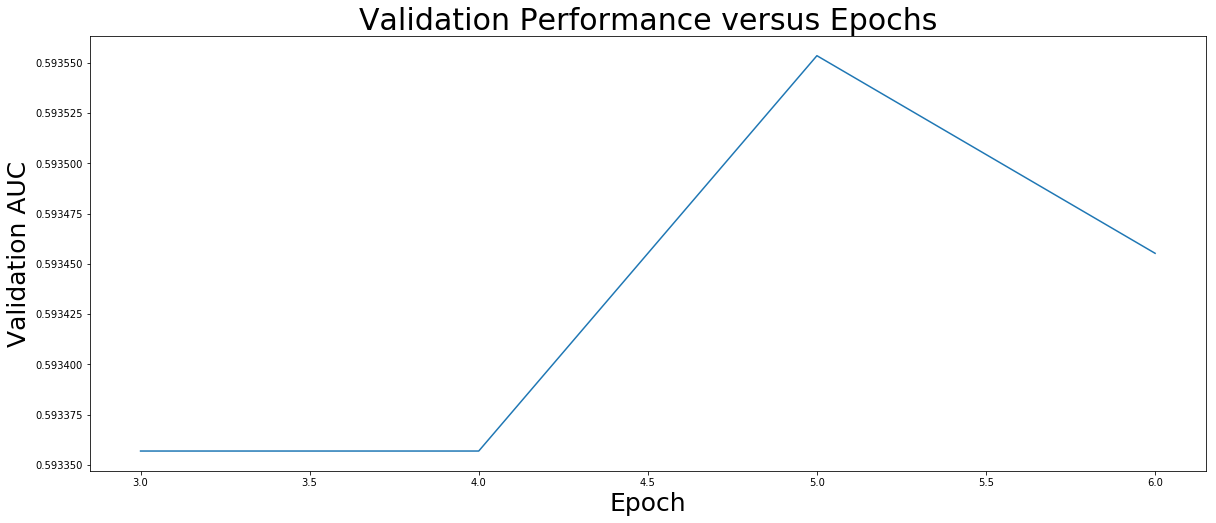

In [26]:
plt.figure(figsize=(20,8))
ax = sns.lineplot(list(range(3, 3 + len(val_metrics))), [m["auc"] for m in val_metrics], palette="GnBu_d")
ax.set_xlabel("Epoch", fontsize=25)
ax.set_ylabel("Validation AUC", fontsize=25)
ax.set_title("Validation Performance versus Epochs", fontsize=30)
plt.show()

Let's look at what some False Negatives and True Positives on the validation set look like to get a feel for how the model did. The true positives have very strong language and usually mention video or images. Some false negatives also have strong language, although others are more dubious. 

In [39]:
predictions = predict(_X_test[[True if y == 1 else False for y in y_test]])

INFO:tensorflow:Writing example 0 of 32


I0614 03:01:20.871289 140533437306240 run_classifier.py:774] Writing example 0 of 32


INFO:tensorflow:*** Example ***


I0614 03:01:20.960754 140533437306240 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0614 03:01:20.963171 140533437306240 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] footage of the massacre in kiev , ukraine today from twitter new images every 15 minutes , video of sniper ##s [SEP]


I0614 03:01:20.965581 140533437306240 run_classifier.py:464] tokens: [CLS] footage of the massacre in kiev , ukraine today from twitter new images every 15 minutes , video of sniper ##s [SEP]


INFO:tensorflow:input_ids: 101 8333 1997 1996 9288 1999 12100 1010 5924 2651 2013 10474 2047 4871 2296 2321 2781 1010 2678 1997 17515 2015 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 03:01:20.967681 140533437306240 run_classifier.py:465] input_ids: 101 8333 1997 1996 9288 1999 12100 1010 5924 2651 2013 10474 2047 4871 2296 2321 2781 1010 2678 1997 17515 2015 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 03:01:20.969773 140533437306240 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 03:01:20.970909 140533437306240 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I0614 03:01:20.972040 140533437306240 run_classifier.py:468] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I0614 03:01:20.974075 140533437306240 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0614 03:01:20.975313 140533437306240 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] a 250 - year - old leather dil ##do has been discovered by archaeologists in an ancient toilet in poland . [SEP]


I0614 03:01:20.976460 140533437306240 run_classifier.py:464] tokens: [CLS] a 250 - year - old leather dil ##do has been discovered by archaeologists in an ancient toilet in poland . [SEP]


INFO:tensorflow:input_ids: 101 1037 5539 1011 2095 1011 2214 5898 29454 3527 2038 2042 3603 2011 19254 1999 2019 3418 11848 1999 3735 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 03:01:20.977689 140533437306240 run_classifier.py:465] input_ids: 101 1037 5539 1011 2095 1011 2214 5898 29454 3527 2038 2042 3603 2011 19254 1999 2019 3418 11848 1999 3735 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 03:01:20.978927 140533437306240 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 03:01:20.980231 140533437306240 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I0614 03:01:20.981483 140533437306240 run_classifier.py:468] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I0614 03:01:20.983189 140533437306240 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0614 03:01:20.984361 140533437306240 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] chinese builder ‘ lucky to be alive ’ after shooting metal bars through his neck [SEP]


I0614 03:01:20.985537 140533437306240 run_classifier.py:464] tokens: [CLS] chinese builder ‘ lucky to be alive ’ after shooting metal bars through his neck [SEP]


INFO:tensorflow:input_ids: 101 2822 12508 1520 5341 2000 2022 4142 1521 2044 5008 3384 6963 2083 2010 3300 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 03:01:20.986724 140533437306240 run_classifier.py:465] input_ids: 101 2822 12508 1520 5341 2000 2022 4142 1521 2044 5008 3384 6963 2083 2010 3300 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 03:01:20.987900 140533437306240 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 03:01:20.989133 140533437306240 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I0614 03:01:20.990330 140533437306240 run_classifier.py:468] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I0614 03:01:20.992271 140533437306240 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0614 03:01:20.993452 140533437306240 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] death toll climbs to 281 , as egyptian security forces crack down on pro mor ##si supporters in pictures [SEP]


I0614 03:01:20.994586 140533437306240 run_classifier.py:464] tokens: [CLS] death toll climbs to 281 , as egyptian security forces crack down on pro mor ##si supporters in pictures [SEP]


INFO:tensorflow:input_ids: 101 2331 9565 18881 2000 22955 1010 2004 6811 3036 2749 8579 2091 2006 4013 22822 5332 6793 1999 4620 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 03:01:20.995841 140533437306240 run_classifier.py:465] input_ids: 101 2331 9565 18881 2000 22955 1010 2004 6811 3036 2749 8579 2091 2006 4013 22822 5332 6793 1999 4620 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 03:01:20.997135 140533437306240 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 03:01:20.998359 140533437306240 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I0614 03:01:20.999621 140533437306240 run_classifier.py:468] label: 0 (id = 0)


INFO:tensorflow:*** Example ***


I0614 03:01:21.001821 140533437306240 run_classifier.py:461] *** Example ***


INFO:tensorflow:guid: None


I0614 03:01:21.003011 140533437306240 run_classifier.py:462] guid: None


INFO:tensorflow:tokens: [CLS] dozens of rotting bodies found at abandoned mexican cr ##ema ##torium [SEP]


I0614 03:01:21.004284 140533437306240 run_classifier.py:464] tokens: [CLS] dozens of rotting bodies found at abandoned mexican cr ##ema ##torium [SEP]


INFO:tensorflow:input_ids: 101 9877 1997 22005 4230 2179 2012 4704 4916 13675 14545 24390 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 03:01:21.005666 140533437306240 run_classifier.py:465] input_ids: 101 9877 1997 22005 4230 2179 2012 4704 4916 13675 14545 24390 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 03:01:21.006902 140533437306240 run_classifier.py:466] input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


I0614 03:01:21.008087 140533437306240 run_classifier.py:467] segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


I0614 03:01:21.009279 140533437306240 run_classifier.py:468] label: 0 (id = 0)


INFO:tensorflow:Calling model_fn.


I0614 03:01:21.092946 140533437306240 estimator.py:1111] Calling model_fn.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0614 03:01:25.968641 140533437306240 saver.py:1483] Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Done calling model_fn.


I0614 03:01:26.148046 140533437306240 estimator.py:1113] Done calling model_fn.


INFO:tensorflow:Graph was finalized.


I0614 03:01:26.698553 140533437306240 monitored_session.py:222] Graph was finalized.


INFO:tensorflow:Restoring parameters from ../model.ckpt-7680


I0614 03:01:26.703760 140533437306240 saver.py:1270] Restoring parameters from ../model.ckpt-7680


INFO:tensorflow:Running local_init_op.


I0614 03:01:27.706847 140533437306240 session_manager.py:491] Running local_init_op.


INFO:tensorflow:Done running local_init_op.


I0614 03:01:27.808812 140533437306240 session_manager.py:493] Done running local_init_op.


In [40]:
# True positives
[p[0] for p in predictions if p[2] == 1]

['Footage of the massacre in Kiev, Ukraine today from Twitter (new images every 15 minutes, video of snipers)',
 'Photographer films his own death by sniper in Egypt. (GRAPHIC.)',
 'NSFW: Gaddefi is doing a crime against humanity. EXTREMELY GRAPHIC IMAGES FROM TRIPOLI. ',
 'Video: GRAPHIC: Mexican Terrorist Cartel Beheads 4 Women In Message To America | Prepper Chimp']

In [41]:
# False negatives
[p[0] for p in predictions if p[2] == 0]

['A 250-year-old leather dildo has been discovered by archaeologists in an ancient toilet in Poland.',
 'Chinese Builder ‘lucky to be alive’ After Shooting Metal Bars Through his Neck',
 'Death toll climbs to 281, as Egyptian security forces crack down on pro Morsi supporters (in pictures)',
 'Dozens of rotting bodies found at abandoned Mexican crematorium',
 '[VIDEO] Aftermath of journalist Michael Hastings car crash. Possibly NSFW.',
 'More bang for your buck - technology changing the world s oldest profession',
 'Ghanaian prostitutes in Nigeria on strike (somewhat NSFW)',
 'Hospital attacked in Central African Republic',
 'Google didn’t comply with Argentina’s request to remove NSFW video of president',
 'In Pictures: Killings in Cairo - NSFW',
 'The United States military is conducting a formal investigation into American soldiers burning the dead bodies of Iraqi insurgents. (NSFW)',
 'Famous Russian Female Body Guard Killed in Carjacking [Semi-NSFW Photos]',
 'Tortured puppies cov